# Computer Vision - Project
imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import h5py
import requests

2023-01-19 20:34:19.573876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 20:34:19.977462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vscode/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-19 20:34:19.977488: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-19 20:34:21.777805: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerr

Constants

In [2]:
#ZIP_PATH = "https://drive.google.com/drive/folders/1jzHYpTwywUYA53nMGHVROSuVO14hEueq?usp=sharing/"
FILE_NAME ="SynthText_train.h5"


In [3]:
import h5py, requests, os
def load_files():    
    #with open(FILE_NAME, "wb") as f:
    #    r = requests.get(ZIP_PATH+FILE_NAME)
    #    f.write(r.content)
    db = h5py.File(FILE_NAME, 'r')
    im_names = list(db['data'].keys())
    im = im_names[0]
    img  = db['data'][im][:]
    #print(img)
    font = db['data'][im].attrs['font']
    #print(font)
    txt = db['data'][im].attrs['txt']
    #print(txt)
    charBB = db['data'][im].attrs['charBB']
    #print(charBB)
    wordBB = db['data'][im].attrs['wordBB']
    #print(wordBB)
    return img, font, txt, charBB, wordBB 

In [4]:
img, font, txt, charBB, wordBB = load_files()
print(wordBB.shape)

(2, 4, 18)


374.43994 500.64325
409
445
357
409
445
357
398
374,445
357,398
T
[b'The' b'the' b'him,' b'the' b'and' b'This' b'with' b'Any' b'From' b'Apr'
 b'This' b'not' b'and' b'core' b'the' b'the' b'all' b'cut']
[b'Titillium Web' b'Titillium Web' b'Titillium Web' b'Alex Brush'
 b'Alex Brush' b'Alex Brush' b'Open Sans' b'Open Sans' b'Open Sans'
 b'Open Sans' b'Open Sans' b'Open Sans' b'Open Sans' b'Alex Brush'
 b'Alex Brush' b'Alex Brush' b'Alex Brush' b'Alex Brush' b'Alex Brush'
 b'Alex Brush' b'Titillium Web' b'Titillium Web' b'Titillium Web'
 b'Titillium Web' b'Sansation' b'Sansation' b'Sansation' b'Sansation'
 b'Sansation' b'Sansation' b'Sansation' b'Sansation' b'Sansation'
 b'Sansation' b'Alex Brush' b'Alex Brush' b'Alex Brush' b'Alex Brush'
 b'Alex Brush' b'Alex Brush' b'Alex Brush' b'Titillium Web'
 b'Titillium Web' b'Titillium Web' b'Sansation' b'Sansation' b'Sansation'
 b'Sansation' b'Titillium Web' b'Titillium Web' b'Titillium Web'
 b'Alex Brush' b'Alex Brush' b'Alex Brush' b'Titillium W

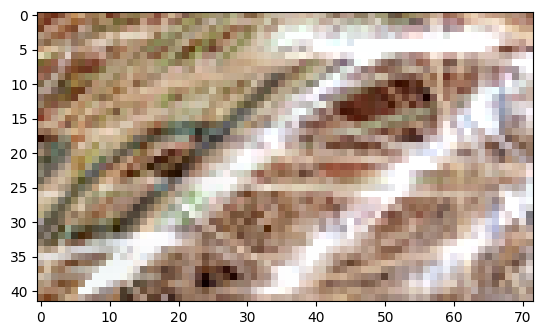

In [5]:
import matplotlib.patches as patches

x = wordBB[0][0][0]
y= wordBB[0][1][0]
print(x,y)
x1 = int(charBB[0,0,0])
x2 = int(charBB[0,1,0])
print(x1)
print(x2)
y1 = int(charBB[1,1,0])
y2 = int(charBB[1,2,0])
print(y1)
x3 = int(charBB[0,2,0])
x4 = int(charBB[0,3,0])
print(x1)
print(x2)
y3 = int(charBB[1,3,0])
y4 = int(charBB[1,0,0])
print(y1)
#rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
print(y2)
# Create figure and axes
#fig, ax = plt.subplots()
# Add the patch to the Axes
#ax.add_patch(rect)
top_left_x = min([x1,x2,x3,x4])
top_left_y = min([y1,y2,y3,y4])
bot_right_x = max([x1,x2,x3,x4])
bot_right_y = max([y1,y2,y3,y4])
print(str(top_left_x)+','+str(bot_right_x))
print(str(top_left_y)+','+str(bot_right_y))
plt.imshow(img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1])
#plt.show()
print(chr(txt[0][0]))
print(txt)
print(font)

In [6]:
def get_bb(img, bbs, indx):
    x1 = int(bbs[0,0,indx])
    x2 = int(bbs[0,1,indx])
    y1 = int(bbs[1,1,indx])
    y2 = int(bbs[1,2,indx])
    x3 = int(bbs[0,2,indx])
    x4 = int(bbs[0,3,indx])
    y3 = int(bbs[1,3,indx])
    y4 = int(bbs[1,0,indx])
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))
    #print(str(top_left_x)+','+str(bot_right_x))
    #print(str(top_left_y)+','+str(bot_right_y))
    return img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]

In [7]:
def font_to_num(font):
    if font == 'Alex Brush':
        return 0
    elif font == 'Titillium Web':
        return 1
    elif font == 'Sansation':
        return 2
    elif font == 'Open Sans':
        return 3
    else:
        return 4

In [8]:
def scale_resize_image(image, size):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (size, size)) # Resizing the image to 224x224 dimention
    return image


In [9]:
db = h5py.File(FILE_NAME, 'r')
im_names = list(db['data'].keys())
train_x = []
train_y = []
for i in range(0, len(im_names)-1):
    #print("i="+str(i))
    im = im_names[i]
    img  = db['data'][im][:]
    fonts = db['data'][im].attrs['font']
    txts = db['data'][im].attrs['txt']
    charBBs = db['data'][im].attrs['charBB']
    wordBBs = db['data'][im].attrs['wordBB']
    #print(len(fonts))
    #print(len(txts))
    font_indx = 0 
    char_indx = 0
    #sum_chars=0
    for j in range(0, len(txts)):
        #print("j="+str(j))
        #print('sum chars='+str(sum_chars))
        #print(txts[j])
        cropped = get_bb(img, wordBBs, j)
        #print(cropped.shape)
        #plt.imshow(cropped)
        #plt.show()
        train_x.append(cropped)
        #print(fonts[font_indx])
        train_y.append(font_to_num(fonts[font_indx]))
        font_indx += len(txts[j])
        for k in range(0, len(txts[j])):
            cropped = get_bb(img, charBBs, char_indx)
            #plt.imshow(cropped)
            #plt.show()
            train_x.append(cropped)
            #print(fonts[char_indx])
            
            train_y.append(font_to_num(fonts[char_indx]))
            char_indx+=1
        #sum_chars+=len(txts[j])
            
    

In [10]:
for i in range(0, len(train_x)):
    train_x[i] = scale_resize_image(train_x[i], 64)

2023-01-19 20:34:51.763533: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vscode/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-19 20:34:51.763956: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-19 20:34:51.764086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6d33a50d07f8): /proc/driver/nvidia/version does not exist
2023-01-19 20:34:51.768046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate com

In [11]:
#cut the set for train and validation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.33, random_state=42)

print(len(x_train))
print(len(x_test))

25394
12508


In [12]:
np.random.seed(123) # for reproducibility
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [13]:
Y_train = np_utils.to_categorical(y_train, 5)
Y_test = np_utils.to_categorical(y_test, 5)

In [14]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', padding='same', input_shape=(64,64,3)))
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [16]:
print(len(x_train))
print(len(Y_train))
X_train = np.array(x_train)
Y_train = np.array(Y_train)
#X_train = X_train.reshape(X_train.shape[0], 1, 64, 64)
#X_train = X_train.astype('float32')
#X_train /= 255
print(X_train.shape)
print(Y_train.shape)
model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)

25394
25394
(25394, 64, 64, 3)
(25394, 5)


2023-01-19 20:35:22.207805: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1248165888 exceeds 10% of free system memory.


Epoch 1/10
794/794 [==============================] - 16s 17ms/step - loss: 0.0099
Epoch 2/10
794/794 [==============================] - 9s 11ms/step - loss: 1.0364e-07
Epoch 3/10
794/794 [==============================] - 8s 10ms/step - loss: 9.6959e-08
Epoch 4/10
794/794 [==============================] - 7s 9ms/step - loss: 4.1502e-08
Epoch 5/10
794/794 [==============================] - 7s 9ms/step - loss: 3.2370e-08
Epoch 6/10
794/794 [==============================] - 8s 10ms/step - loss: 5.6612e-09
Epoch 7/10
794/794 [==============================] - 7s 9ms/step - loss: 9.0132e-10
Epoch 8/10
794/794 [==============================] - 8s 10ms/step - loss: 1.6571e-09
Epoch 9/10
794/794 [==============================] - 7s 9ms/step - loss: 2.5396e-09
Epoch 10/10
794/794 [==============================] - 8s 10ms/step - loss: 3.9902e-10


In [17]:
X_test = np.array(x_test)
score = model.evaluate(X_test, Y_test, verbose=0)

2023-01-19 20:38:19.715440: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 614793216 exceeds 10% of free system memory.


In [18]:
print(score)

0.0
